# The Golden Spiral Dataset

## Definition

*Note: This introduction is largely inspired from the [Golden Spiral wikipedia page](https://en.wikipedia.org/wiki/Golden_spiral).*

A golden spiral is a logarithmic spiral whose growth factor is $\varphi$, the golden ratio:

$$
\varphi = \frac{1 + \sqrt{5}}{2}
$$

The polar equation for a golden spiral is the same as for other logarithmic spirals, but with a special value of the growth factor $b$:

$$
r = ae^{b\theta} 
$$

or

$$
\theta = \frac{1}{b} \ln(r/a)
$$

with $e$ being the base of natural logarithms, $a$ being the initial radius of the spiral, and $b$ such that when $\theta$ is a right angle (a quarter turn in either direction):

$$
e^{b\theta_\mathrm{right}}\, = \varphi
$$

Therefore, $b$ is given by:

$$
b = {\ln{\varphi} \over \theta_\mathrm{right}}.
$$

In parametric form, the curve is

$$
x(t) = r(t) \cos(t) = ae^{bt} \cos(t)
\\
y(t) = r(t) \sin(t) = ae^{bt} \sin(t)
$$

## Properties of logarithmic spiral

The arc length $s$ and the curvature $\kappa$ of the logarithmic spiral are given by:

$$
s(t) = \frac{a\sqrt{1 + b^2}e^{bt}}{b}
\\
\kappa (t) = \frac{ e^{-bt} } {a\sqrt{1 + b^2}}
$$

where $t$ is the tangential angle.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tifffile
from scipy import signal
from scipy import ndimage

import sys; sys.path.append(str(Path("../../")))
import pykappa

data_dir = Path("/home/hadim/.data/Postdoc/Kappa/spiral_curve_SDM")
data_dir.mkdir(exist_ok=True)

variable_snr_dir = data_dir / "variable_snr"
variable_pixel_size_dir = data_dir / "variable_pixel_size"
variable_initial_position_dir = data_dir / "variable_initial_position"
variable_psf_size_dir = data_dir / "variable_psf_size"

theoretical_curvatures_fname = "Original_Curve.csv"
original_curve_fname = "Original_Curve.tif"
original_curve_non_convoluted_fname = "Original_Curve_Non_Convoluted.tif"

# We use a small pixel size for the 
# original image that will be used 
# to build all the different dataset.
original_pixel_size = 0.01  # um

offset = 200  # pixel

signal_value = 100

initial_radius = 5  # um
spiral_length = 9  # um
spiral_step_size = 0.001  # um

fixed_snr = 20  # dB
fixed_pixel_size = 0.16  # um/pixel

## Build the original image

This original image will be used to build all the dataset.

/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


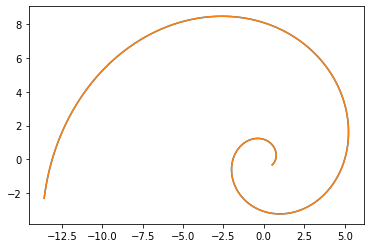

In [2]:
# Golden ratio
phi = (1 + np.sqrt(5)) / 2

# Initial radius
a = initial_radius

# Growth factor
b = np.log(phi) / np.deg2rad(90)

# Define spiral length
t = np.arange(0, spiral_length, spiral_step_size)

# `t` is scaled to get even spacing between computed points.
t = np.log(b * t) / b

# We remove the first data points that are too curved.
# See https://computergraphics.stackexchange.com/questions/5735/logarithmic-spiral-with-equal-vertex-spacing-what-equations
t = t[400:]

# Compute curvatures
kappa = (np.exp(-1 * b * t)) / (a * np.sqrt(1 + b**2))

# Compute arc length
t0 = 0
l = (np.sqrt(a**2 * (b**2 + 1)) * (np.sqrt(np.exp(2*b*t)) - (np.sqrt(np.exp(2*b*t0))))) / b

# Compute positions
xx = a * np.exp(b * t) * np.cos(t)
yy = a * np.exp(b * t) * np.sin(t)

xx2 = a*phi**(t*2/np.pi) * np.cos(t)
yy2 = a*phi**(t*2/np.pi) * np.sin(t)

plt.plot(xx, yy)
plt.plot(xx2, yy2)

In [3]:
kappa.mean()

0.2260757407181085

In [4]:
# Golden ratio
phi = (1 + np.sqrt(5)) / 2

# Initial radius
a = initial_radius

# Growth factor
b = np.log(phi) / np.deg2rad(90)

# Define spiral length
t = np.arange(0, spiral_length, spiral_step_size)

# `t` is scaled to get even spacing between computed points.
t = np.log(b * t) / b

# We remove the first data points that are too curved.
# See https://computergraphics.stackexchange.com/questions/5735/logarithmic-spiral-with-equal-vertex-spacing-what-equations
t = t[400:]

# Compute curvatures
kappa = (np.exp(-1 * b * t)) / (a * np.sqrt(1 + b**2))

# Compute arc length
t0 = 0
l = (np.sqrt(a**2 * (b**2 + 1)) * (np.sqrt(np.exp(2*b*t)) - (np.sqrt(np.exp(2*b*t0))))) / b

# Compute positions
xx = a * np.exp(b * t) * np.cos(t)
yy = a * np.exp(b * t) * np.sin(t)

origin = np.array([xx.min(), yy.min()])
xx -= xx.min()
yy -= yy.min()

xx += offset * original_pixel_size
yy += offset * original_pixel_size

# Save curvature data
curvatures = {"tangential_angle": t, "curvature (1/um)": kappa, "arc length (um)": l, "x (um)": xx, "y (um)": yy}
curvatures = pd.DataFrame(curvatures)
curvatures["curvature (1/pixel)"] = curvatures["curvature (1/um)"] * original_pixel_size
curvatures["arc length (pixel)"] = curvatures["arc length (um)"] / original_pixel_size
curvatures["x (pixel)"] = curvatures["x (um)"] / original_pixel_size
curvatures["y (pixel)"] = curvatures["y (um)"] / original_pixel_size
curvatures.to_csv(data_dir / theoretical_curvatures_fname)

# Convert to pixel
xx_pixel = curvatures["x (pixel)"]
yy_pixel = curvatures["y (pixel)"]

/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [5]:
# Discretize dimers positions onto an image
x_max = int(np.round(xx_pixel.max() + 1))
x_min = int(np.round(xx_pixel.min() - 1))
y_max = int(np.round(yy_pixel.max() + 1))
y_min = int(np.round(yy_pixel.min() - 1))

x_bins = np.arange(x_min - offset, x_max + offset, 1)
y_bins = np.arange(y_min - offset, y_max + offset, 1)

# Bin dimers positions to a 2D grid (defined by pixel_size)
im, _, _ = np.histogram2d(xx_pixel, yy_pixel, bins=[x_bins, y_bins])

# We set all spiral pixels to the same value
im[im > 0] = signal_value

# Save the non convoluted image
im_non_convoluted = pykappa.imaging.rescale_to_8bit(im.copy())
tifffile.imsave(str(data_dir / original_curve_non_convoluted_fname), im_non_convoluted)

# Convolution with a gaussian with a sigma of 100 nm (0.1 um)
sigma = 0.3 / original_pixel_size
kernel = pykappa.imaging.gaussian_kernel(size=sigma * 2.5, sigma=sigma)
im = signal.convolve2d(im, kernel, mode="same")

# Rescale to 8 bits
im = pykappa.imaging.rescale_to_8bit(im)

# Save the image
tifffile.imsave(str(data_dir / original_curve_fname), im)

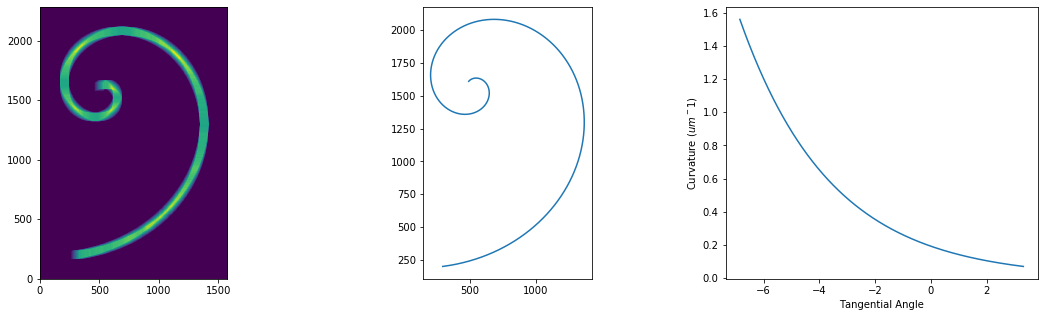

In [6]:
# Plot original image and associated curvature
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(19, 5))
ax1.imshow(im, interpolation='none', aspect='equal', origin=[0, 0])
ax2.plot(yy_pixel, xx_pixel)
ax2.set_aspect('equal')
ax3.plot(curvatures["tangential_angle"], curvatures["curvature (1/um)"])
ax3.set_xlabel("Tangential Angle")
ax3.set_ylabel("Curvature ($um^-1$)")
fig.savefig((data_dir / theoretical_curvatures_fname).with_suffix('.png'))

### Plot Image Generation Process

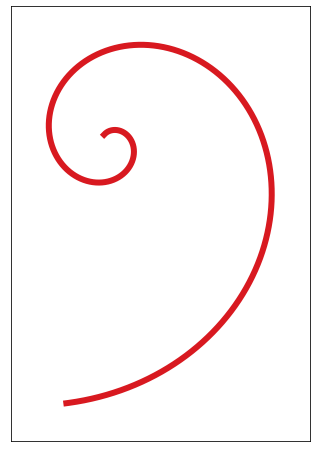

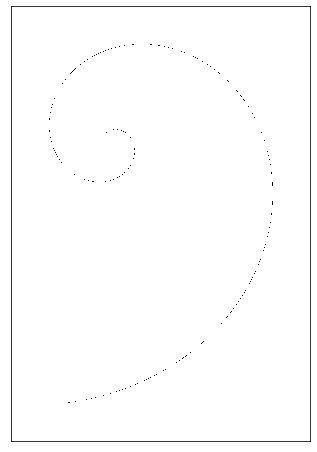

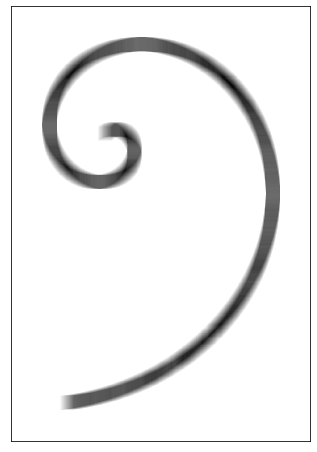

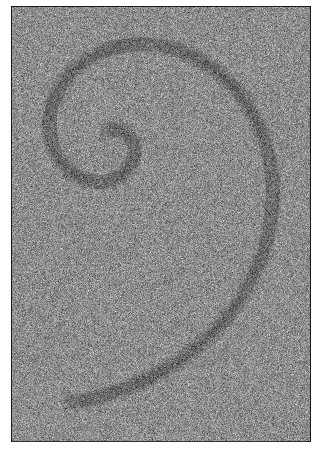

In [7]:
generation_dir = data_dir / "image_generation_process"
generation_dir.mkdir(exist_ok=True)

image_size = im.shape

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.plot(yy_pixel, xx_pixel, lw=6, color="#d81920ff")
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "1_coordinates.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.imshow(np.invert(im_non_convoluted), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "2_discretization.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.imshow(np.invert(im), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "3_convolution.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
im_noise = pykappa.imaging.awgn(im, 12*3)
im_noise = pykappa.imaging.rescale_to_8bit(im_noise)
ax.imshow(np.invert(im_noise), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "4_noise.png", bbox_inches='tight',transparent=False)

### Build the "Variable SNR" dataset

In [8]:
# Generates images with differing signal to noise ratios.
# Lowers image intensity too.

variable_snr_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

snr_range = np.arange(0, 26, 1)  # dB
n = len(snr_range)

scale_factor = original_pixel_size / fixed_pixel_size

# Compute initialization curves
original_curves = pykappa.data.get_spiral_curves()
curves = pykappa.io.transform_positions(original_curves.copy(), lambda x: x * scale_factor)

for snr in tqdm(snr_range, total=n):
    
    # Apply scale factor
    im = ndimage.zoom(original_image, scale_factor, order=1)
    
    # Adjust SNR
    im = pykappa.imaging.awgn(im, snr)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_snr_dir / f"snr_{snr:02}_dB.tif"
    tifffile.imsave(str(fname), im)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)

/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


### Build the "Variable Pixel Size" dataset

In [9]:
# Generates images with reduced effective pixel size by scaling.
# Rescaling is done with bilinear interpolation.

variable_pixel_size_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

pixel_size_range = np.arange(0.01, 0.41, 0.02)  # um/pixel
n = len(pixel_size_range)

# Compute initialization curves
original_curves = pykappa.data.get_spiral_curves()

for pixel_size in tqdm(pixel_size_range, total=n):
    
    # Compute the desired scale factor
    scale_factor = original_pixel_size / pixel_size
    
    im = original_image.copy()
    
    # Adjust SNR
    im = pykappa.imaging.awgn(im, 40)
    
    # Apply the scale factor to the original image
    im = ndimage.zoom(im, scale_factor, order=1)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_pixel_size_dir / f"pixel_size_{pixel_size:0.2f}_um.tif"
    tifffile.imsave(str(fname), im)
    
    # Scale initialization curves
    curves = pykappa.io.transform_positions(original_curves, lambda x: x * scale_factor)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)

### Build the "Variable Initial Curve" dataset

In [10]:
# Copy the same image with different name. They will
# be fitted with different initial curves.

variable_initial_position_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

initial_position_noise_range = np.arange(0.1, 1.4, 0.1)  # um
n = len(initial_position_noise_range)

# Compute image
im = ndimage.zoom(original_image, original_pixel_size / fixed_pixel_size, order=1)
im = pykappa.imaging.awgn(im, fixed_snr)
im = pykappa.imaging.rescale_to_8bit(im)

# Compute initialization curves
original_curves = pykappa.data.get_spiral_curves()
scale_factor = original_pixel_size / fixed_pixel_size
original_curves = pykappa.io.transform_positions(original_curves, lambda x: x * scale_factor)

# Function to add some noise to init curves
def add_noise(pos, noise_pixel):
    if noise_pixel > 0:
        pos += np.random.normal(loc=0, scale=noise_pixel, size=pos.shape)
    return pos

for initial_position_noise in tqdm(initial_position_noise_range, total=n):
    
    # Save image as TIF
    fname = variable_initial_position_dir / f"initial_position_noise_{initial_position_noise:0.2f}_au.tif"
    tifffile.imsave(fname, im)
    
    # Add noise to initialization curves
    noise_pixel = initial_position_noise / fixed_pixel_size
    noisy_curves = pykappa.io.transform_positions(original_curves, lambda pos: add_noise(pos, noise_pixel))
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(noisy_curves, kappa_path)

### Build the "Variable PSF Size" dataset

In [6]:
# Generates images with different PSF size.
# No noise added to the image.

variable_psf_size_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_non_convoluted_fname))

psf_size_range = [0, 0.05, 0.2, 0.3, 0.6, 0.8, 1.0]  # um
n = len(psf_size_range)

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()

# # Compute the desired scale factor
# pixel_size = 0.04
# scale_factor = original_pixel_size / pixel_size
pixel_size = original_pixel_size

# Compute initialization curves
original_curves = pykappa.data.get_spiral_curves()
# curves = pykappa.io.transform_positions(original_curves.copy(), lambda x: x * scale_factor)
curves = original_curves

for psf_size in tqdm(psf_size_range, total=n):

    im = original_image.copy()
    
    # Convolve the image
    if psf_size > 0:
        sigma = psf_size / pixel_size
        kernel = pykappa.imaging.gaussian_kernel(size=sigma * 2.5, sigma=sigma)
        im = signal.convolve2d(im, kernel, mode="same")
    
    # Apply the scale factor to the convolved image
    #im = ndimage.zoom(im, scale_factor, order=1)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_psf_size_dir / f"psf_size_{psf_size:0.2f}_um.tif"
    tifffile.imsave(str(fname), im)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)